In [197]:
# Variate K
# for loading/processing the images
from keras.utils import load_img
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd

plt.style.use('dark_background')


In [198]:


flower_images_path = f'{os.getcwd()}/flower_images'

# this list holds all the image filename
flowers = []

# creates a ScandirIterator aliased as files
with os.scandir(flower_images_path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            flowers.append(file.name)

In [199]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)


In [200]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224, 224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1, 224, 224, 3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True, verbose=0)
    return features


In [201]:

data = {}

# loop through each image in the dataset
for flower in flowers:
    flower_img_path = f'{flower_images_path}/{flower}'
    feat = extract_features(flower_img_path, model)
    data[flower] = feat
# get a list of the filenames
filenames = np.array(list(data.keys()))


In [202]:
# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1, 4096)

flower_labels_path = f'{flower_images_path}/flower_labels.csv'

# get the unique labels (from the flower_labels.csv)
df = pd.read_csv(flower_labels_path)
label = df['label'].tolist()
unique_labels = list(set(label))

# reduce the amount of dimensions in the feature vector






['591.56', '296.74', '229.59', '197.79', '161.59', '145.97', '121.06', '102.47', '95.16', '94.13', '80.91', '74.44', '67.46', '60.83', '57.14', '49.60', '48.15', '44.77', '41.96', '40.35', '39.94', '36.21', '34.43', '33.23', '31.08', '30.83', '28.15', '26.79', '25.43', '24.81']


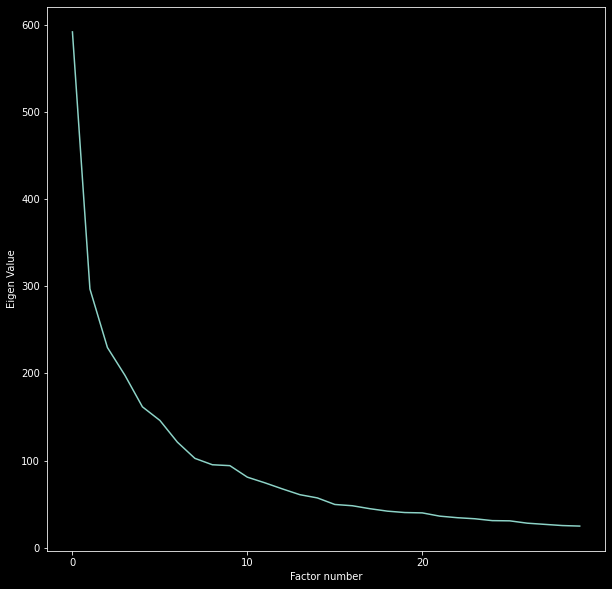

In [203]:


pca = PCA(n_components= 30)
pca.fit(feat)
x = pca.transform(feat)
eigval = pca.explained_variance_
["%0.2f" % i for i in eigval]
print(["%0.2f" % i for i in eigval])

plt.figure(figsize=(10,10))
plt.plot(np.arange(len(eigval)), eigval)
plt.xticks(np.arange(0, len(eigval), step=10))
plt.ylabel("Eigen Value")
plt.xlabel("Factor number")

plt.show()

In [204]:
# cluster feature vectors
kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
kmeans.fit(x)


# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [205]:
# function that lets you view a cluster (based on identifier)
def view_cluster(cluster):
    plt.figure(figsize=(25, 25))
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        file_path = f'{flower_images_path}/{file}'
        plt.subplot(10, 10, index+1)
        img = load_img(file_path)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')


Text(0, 0.5, 'Sum of squared distance')

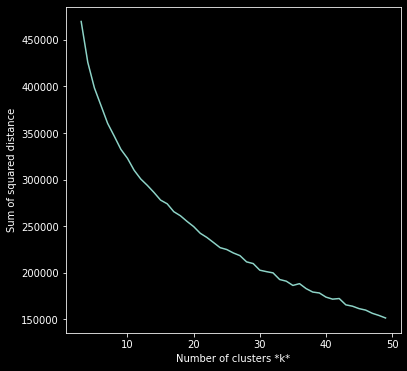

In [206]:
# this is just in case you want to see which value for k might be the best
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=44)
    km.fit(x)

    sse.append(km.inertia_)
    
# Plot sse against k

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')


Clipping cluster size from 35 to 30
Clipping cluster size from 32 to 30


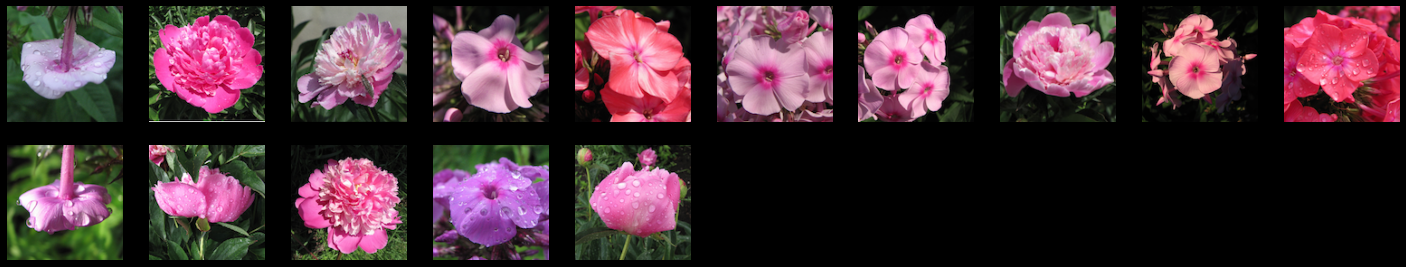

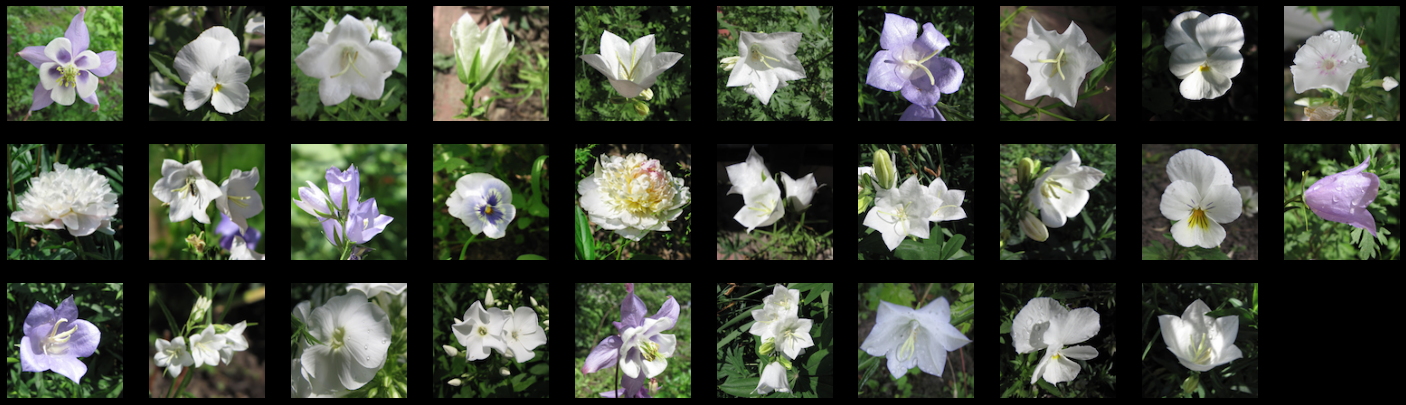

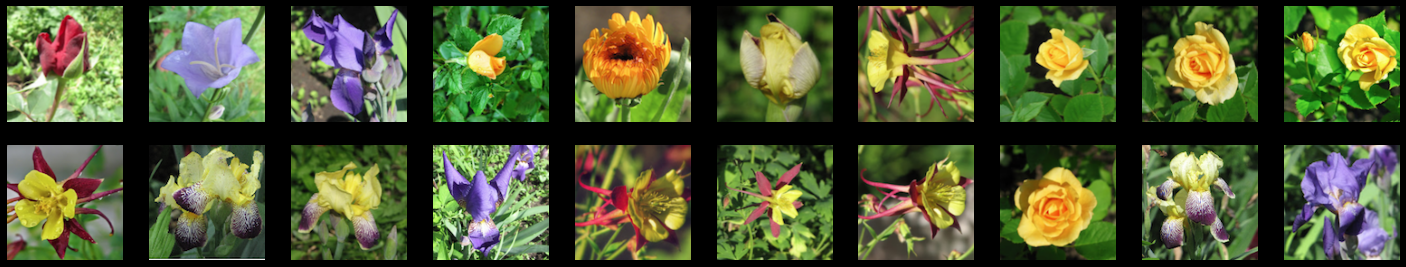

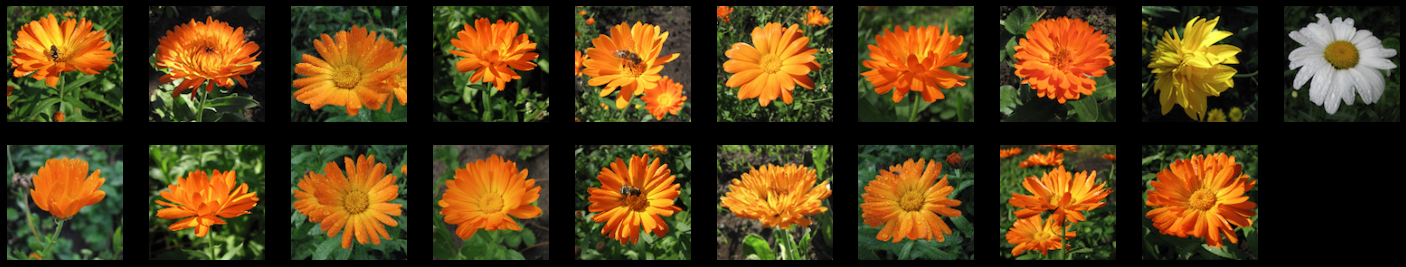

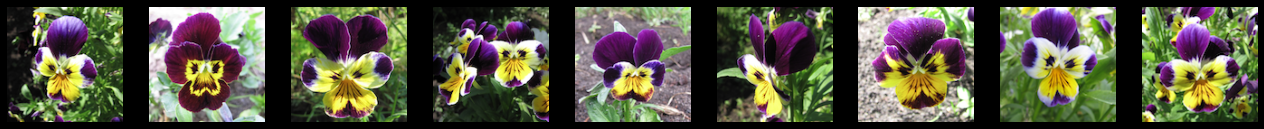

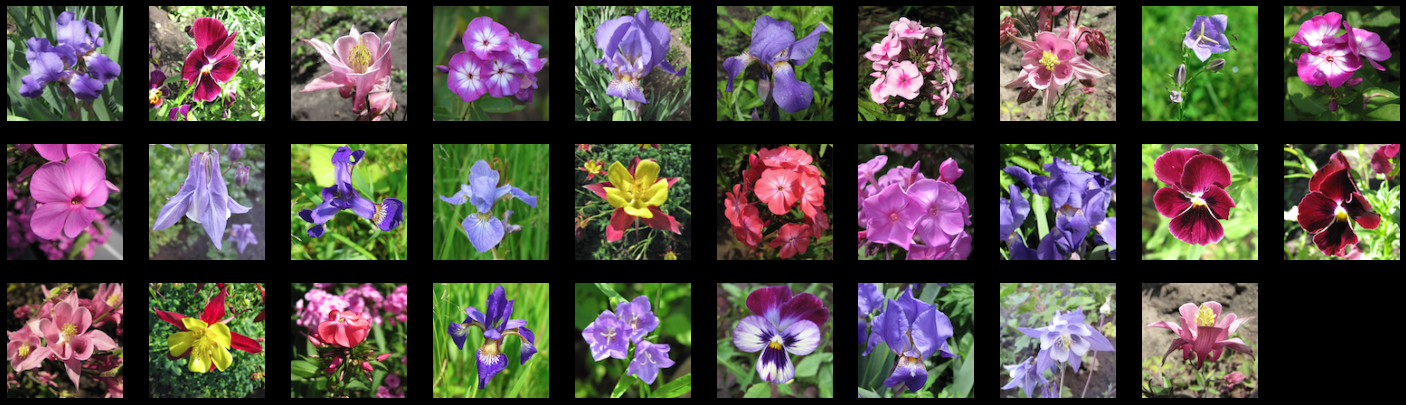

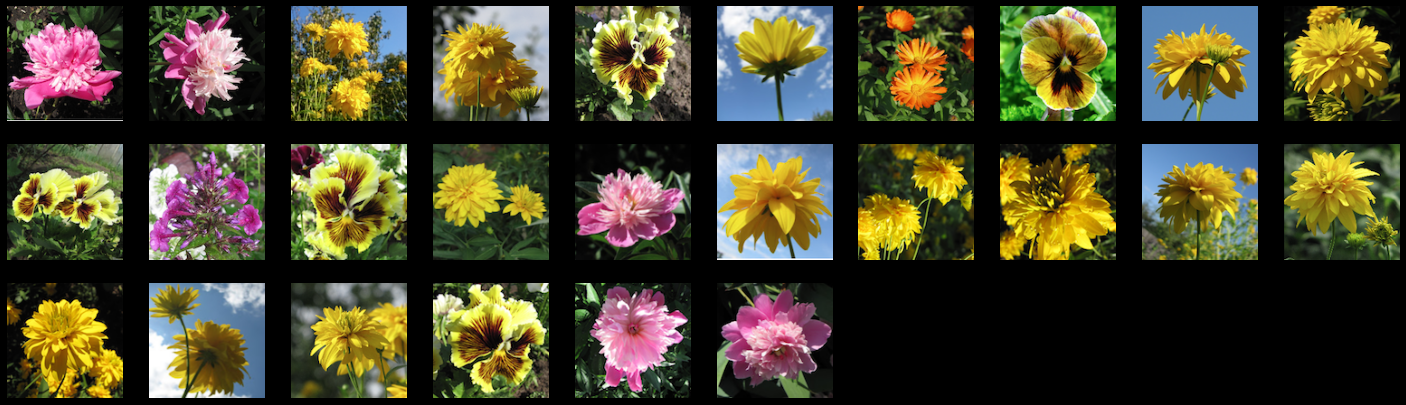

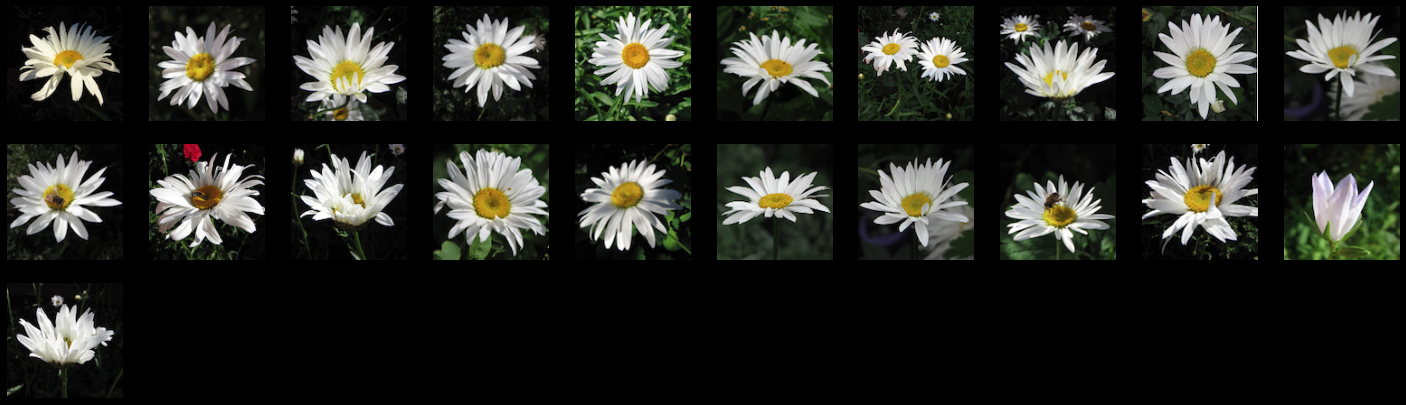

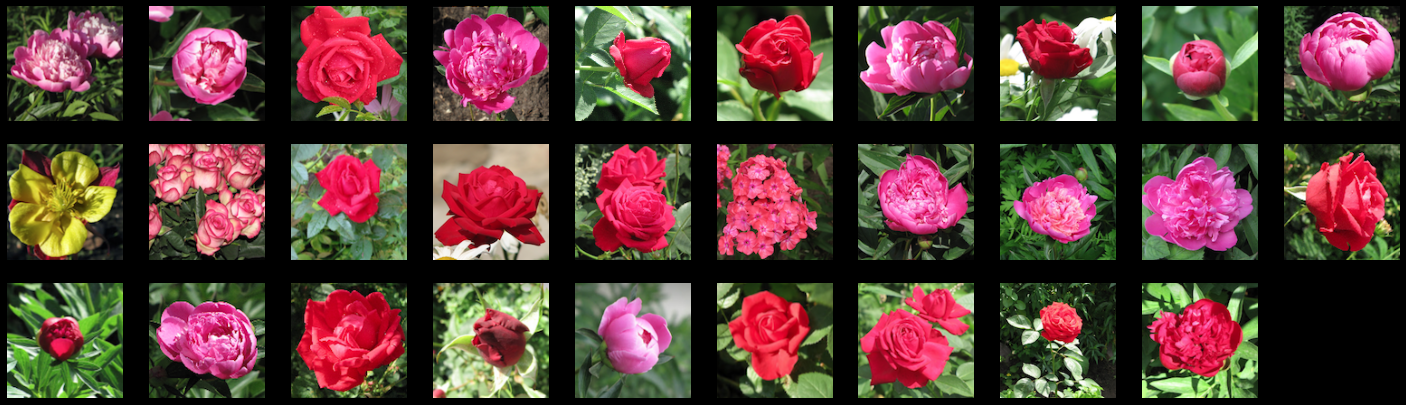

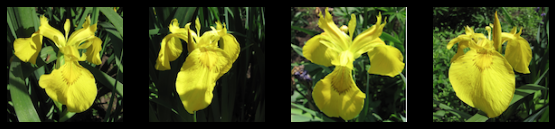

In [207]:
#view_cluster(3)
for cluster in groups.keys():
  view_cluster(cluster)